In [30]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from plotnine import *

from sklearn.tree import DecisionTreeClassifier # Decision Tree
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn import metrics 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder

import scipy.cluster.hierarchy as sch
from matplotlib import pyplot as plt

from sklearn.linear_model import LogisticRegression 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold 
from sklearn.model_selection import LeaveOneOut 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict 
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelBinarizer

%matplotlib inline

# Part 1

In [31]:
bp = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/burgersOrPizza.csv")
bp.head()

,Item_Name,Item_Description,Food_Category,Calories,Total_Fat,Saturated_Fat,Trans_Fat,Cholesterol,Sodium,Potassium,...,Total_Fat_100g,Saturated_Fat_100g,Trans_Fat_100g,Cholesterol_100g,Sodium_100g,Potassium_100g,Carbohydrates_100g,Protein_100g,Sugar_100g,Dietary_Fiber_100g
0,Chicken n Cheese Slider,Chicken n Cheese Slider on Mini Bun w/ Chicken...,Burgers,290.0,12.0,3.5,0.0,25.0,720.0,NaN,...,12,4,0.0,25,727,NaN,30,15,1.0,1.0
1,Corned Beef n Cheese Slider,Corned Beef n Cheese Slider on Mini Bun w/ Cor...,Burgers,220.0,9.0,3.5,0.0,30.0,890.0,NaN,...,10,4,0.0,33,978,NaN,23,15,1.0,1.0
2,Ham n Cheese Slider,Ham n Cheese Slider on Mini Bun w/ Roast Ham &...,Burgers,230.0,9.0,3.5,0.0,30.0,750.0,NaN,...,10,4,0.0,33,824,NaN,24,14,3.0,1.0
3,Jalapeno Roast Beef n Cheese Slider,Jalapeno Roast Beef n Cheese Slider on Mini Bu...,Burgers,240.0,11.0,4.5,0.0,30.0,670.0,NaN,...,11,5,0.0,31,684,NaN,21,14,1.0,1.0
4,Roast Beef n Cheese Slider,Roast Beef n Cheese Slider on Mini Bun w/ Roas...,Burgers,240.0,11.0,4.5,0.0,30.0,670.0,NaN,...,12,5,0.0,33,736,NaN,23,15,1.0,1.0


# Explore Data

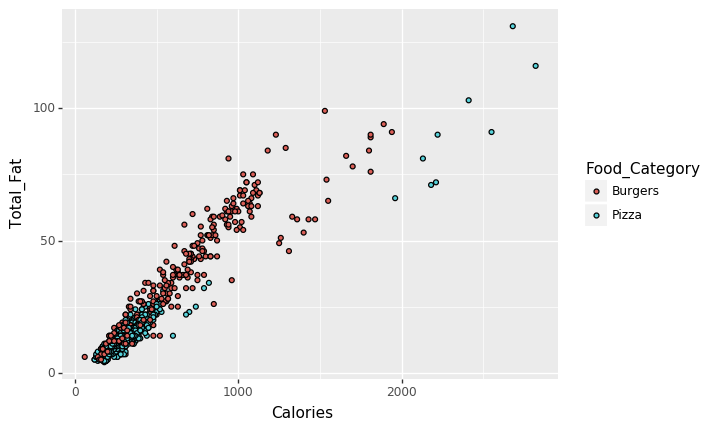

<ggplot: (289976429)>

In [39]:
ggplot(bp, aes("Calories", "Total_Fat")) + geom_point(aes(fill = "Food_Category"))

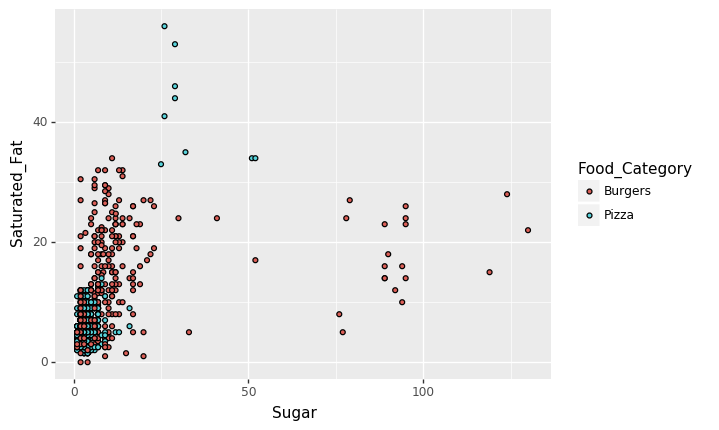

<ggplot: (289880601)>

In [41]:
ggplot(bp, aes("Sugar", "Saturated_Fat")) + geom_point(aes(fill = "Food_Category"))

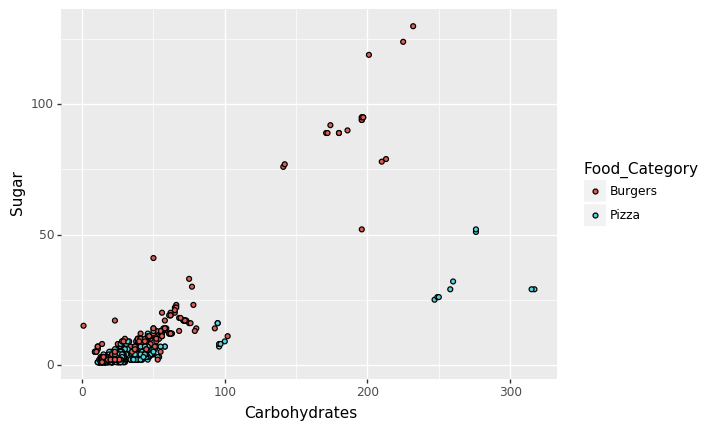

<ggplot: (302510417)>

In [43]:
ggplot(bp, aes("Carbohydrates", "Sugar", fill = "Food_Category")) + geom_point()

# Variable Selection, Model Selection, and Z-standarization

I am chosing to use all continuous variables to give my model maximum prediction power. However I do remove all the na's. Doing this will help my prediction without overwelming the model because it is not a large dataset. 

Due to the fact that this is a small dataset, I chose to use k fold cross validation with 8 folds. Though running LOOCV would not burden the model because of the size of the dataset, I felt K fold would still be able to do the trick especially looking at 10 different folds. 

I chose to standardize my variables because they're measured in different units and scales.

# Loading in Data / Zscoring

In [45]:
features = bp.columns[1:20]
X = bp[features]
y = bp["Food_Category"]

bp = bp.dropna() 

b = LabelBinarizer()
y = b.fit_transform(y)

z = StandardScaler()
z.fit(X)
X[features] = z.transform(X)

# 1. Logistic Regression

0.8333333333333334


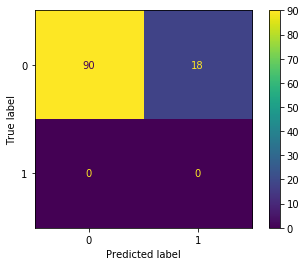

In [46]:
kf = KFold(n_splits = 8)
kf.split(X)
lr = LogisticRegression()
acc = []

for train_indices, test_indices in kf.split(X):
    X_train = X.iloc[train_indices]
    X_test  = X.iloc[test_indices]
    y_train = y[train_indices]
    y_test  = y[test_indices]
  
    model = lr.fit(X_train, y_train)
    acc.append(accuracy_score(y_test, model.predict(X_test)))
    
chosen_k = max(acc)
lr_final = lr.fit(X_train,y_train)
plot_confusion_matrix(lr_final, X_test, y_test)
print(lr_final.score(X_test,y_test))

This model appeared to perform very well with an accuracy score of 83.3% I used the kfold model to measure the performance on 10 different models. The best models had 90 correct predictions and 18 incorrect predictions.

# 2. K Nearest Neighbors

{3: 0.9595349807110832, 4: 0.9653008028359921, 5: 0.9551871546241267, 6: 0.9522990303409447, 7: 0.9494213324992179}


0.9653179190751445

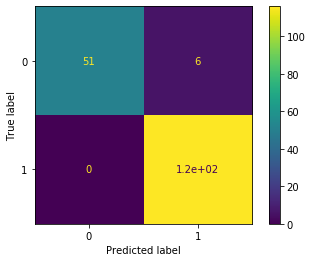

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

poss_k = [3,4,5,6,7]
acc = {}

for k in poss_k:
    kf = KFold(n_splits = 5)
    knn = KNeighborsClassifier(n_neighbors = k)
    acc[k] = np.mean(cross_val_score(knn, X_train, y_train, cv = kf))

print(acc)

chosen_k = max(acc, key=acc.get)

knn_final = KNeighborsClassifier(n_neighbors = chosen_k)
knn_final.fit(X_train,y_train)
plot_confusion_matrix(knn_final, X_test, y_test)

knn_final.score(X_test,y_test)

My K Nearest Neighbors model performed alot better than the Logistics Regression model with my best model performing at an accuracy score of 96.5% Predicting 171 correct predictions and 6 incorrect predictions

# 3. Decision Tree

[0.9541284403669725, 0.9722222222222222, 0.9259259259259259, 0.9629629629629629, 0.9444444444444444, 0.9722222222222222, 0.9537037037037037, 0.9814814814814815]
0.958386425416242
[15, 13, 13, 16, 15, 13, 12, 15]


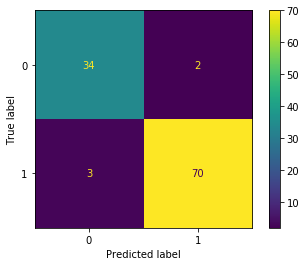

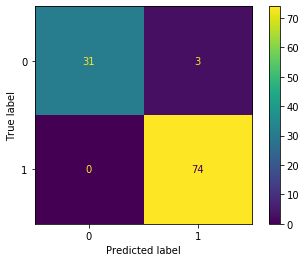

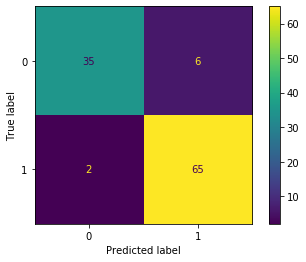

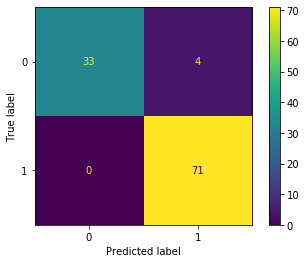

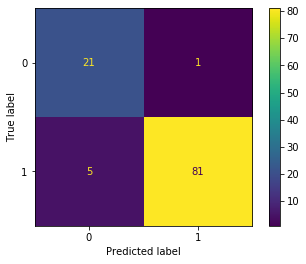

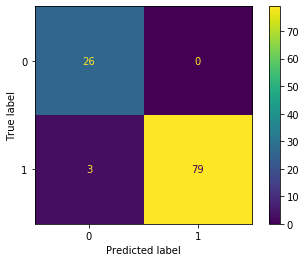

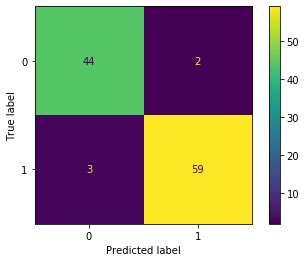

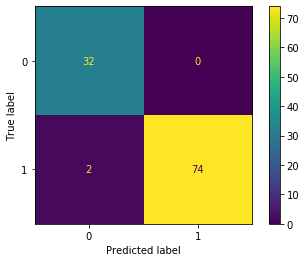

In [49]:
kf = KFold(8, shuffle = True)
acc = []
depth = []

for train, test in kf.split(X):
    X_train = X.iloc[train,]
    X_test = X.iloc[test,]
    y_train = y[train]
    y_test = y[test]
    
    tree = DecisionTreeClassifier()
    tree_mod = tree.fit(X_train,y_train)
    
    acc.append(tree.score(X_test,y_test))
    depth.append(tree.get_depth())
    plot_confusion_matrix(tree_mod, X_test, y_test)

print(acc)
print(np.mean(acc))
print(depth)

My Decision Tree model appeared to perform very well also with an average accuracy score of 95.8% across 8 folds. 

# Best Model

Logistic = 83% accuracy score

KNN = 96% accuracy score

Decision Tree = 95% accuracy score


According to these accuracy scores KNN and Decision Trees appear to be the best models for prediction. Some of the Logistic Regression models inaccuracy could be because the model may be overfit which is reflected in the accuracy score. 

# Part II

In [50]:
kk = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/KrispyKreme.csv")
kk.head()

,Restaurant_Item_Name,restaurant,Restaurant_ID,Item_Name,Item_Description,Food_Category,Serving_Size,Serving_Size_text,Serving_Size_Unit,Serving_Size_household,...,Total_Fat_100g,Saturated_Fat_100g,Trans_Fat_100g,Cholesterol_100g,Sodium_100g,Potassium_100g,Carbohydrates_100g,Protein_100g,Sugar_100g,Dietary_Fiber_100g
0,Krispy Kreme Apple Fritter,Krispy Kreme,49,Apple Fritter,"Apple Fritter, Doughnuts",Baked Goods,100,NaN,g,NaN,...,19,9,0,0,110,45.0,42,4,26,1.0
1,Krispy Kreme Chocolate Iced Cake Doughnut,Krispy Kreme,49,Chocolate Iced Cake Doughnut,"Chocolate Iced Cake Doughnut, Doughnuts",Baked Goods,71,NaN,g,NaN,...,18,7,0,35,437,49.0,52,4,27,NaN
2,Krispy Kreme Chocolate Iced Custard Filled Dou...,Krispy Kreme,49,Chocolate Iced Custard Filled Doughnut,"Chocolate Iced Custard Filled Doughnut, Doughnuts",Baked Goods,85,NaN,g,NaN,...,18,8,0,0,165,59.0,44,5,20,1.0
3,Krispy Kreme Chocolate Iced Glazed Doughnut,Krispy Kreme,49,Chocolate Iced Glazed Doughnut,"Chocolate Iced Glazed Doughnut, Doughnuts",Baked Goods,63,NaN,g,NaN,...,17,8,0,0,143,56.0,52,5,32,NaN
4,Krispy Kreme Chocolate Iced Glazed Cruller Dou...,Krispy Kreme,49,Chocolate Iced Glazed Cruller Doughnut,"Chocolate Iced Glazed Cruller Doughnut, Doughnuts",Baked Goods,70,NaN,g,NaN,...,14,6,0,29,386,29.0,57,4,37,NaN


# 1. Explore Data (K-Means)

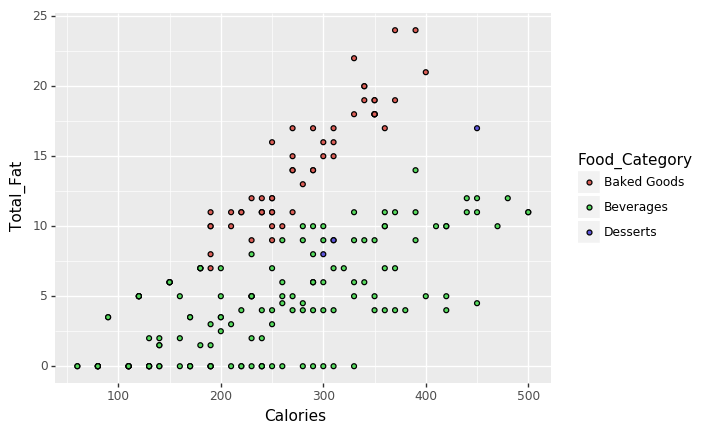

<ggplot: (304478981)>

In [51]:
ggplot(kk, aes("Calories", "Total_Fat")) + geom_point(aes(fill = "Food_Category"))

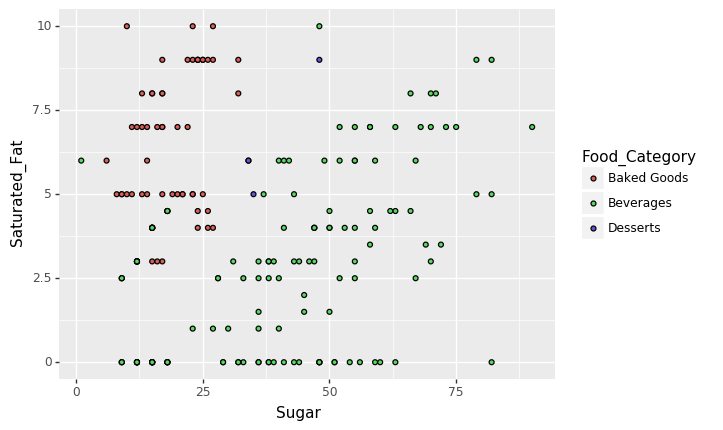

<ggplot: (304373889)>

In [52]:
ggplot(kk, aes("Sugar", "Saturated_Fat")) + geom_point(aes(fill = "Food_Category"))

# 2. Variable Selection (K-Means)

I am going to use the variables: Calories, Total_Fat, Saturated_Fat, and Sugar. These variables appear to be the best when it comes to identifying which food Category the item of food is in. 

# 3. Evaluate Model (K-Means)

In [53]:
features = ["Calories","Total_Fat", "Saturated_Fat", "Sugar"]
X = kk[features]

z = StandardScaler()
X[features] = z.fit_transform(X)

n_components = [2,3,4,5,6]

sils = []
for n in n_components:
    km = KMeans(n_clusters = n)
    km.fit(X)
    membership = km.predict(X)
    X["cluster"] = membership
    sils.append(silhouette_score(X, membership))
    
print(sils)

[0.42234233743207067, 0.49575674269334263, 0.5124874255637523, 0.5932819918512732, 0.5299262302970517]


6 clusters was the best fit for the KNN model

# 4. Describe the cluster (K-Means)

 The Clusters for the KNN model seem to be evenly dispersed. However on of the clusters seems to follow a positive linear path whereas the other cluster is more spread out and random. 

# 1. Explore Data (Gaussian)

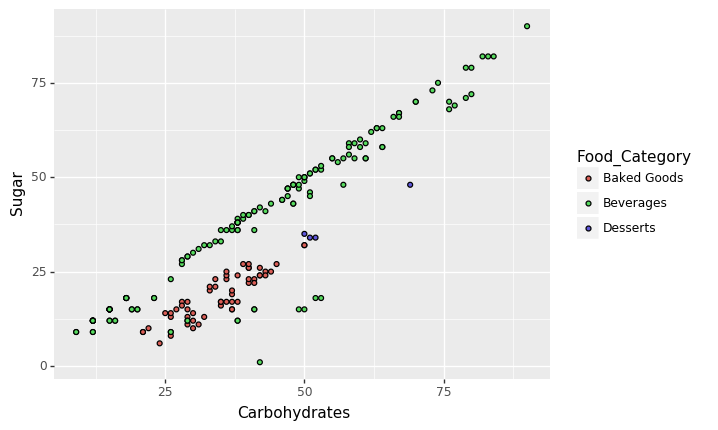

<ggplot: (302428997)>

In [54]:
ggplot(kk, aes("Carbohydrates", "Sugar", fill = "Food_Category")) + geom_point()

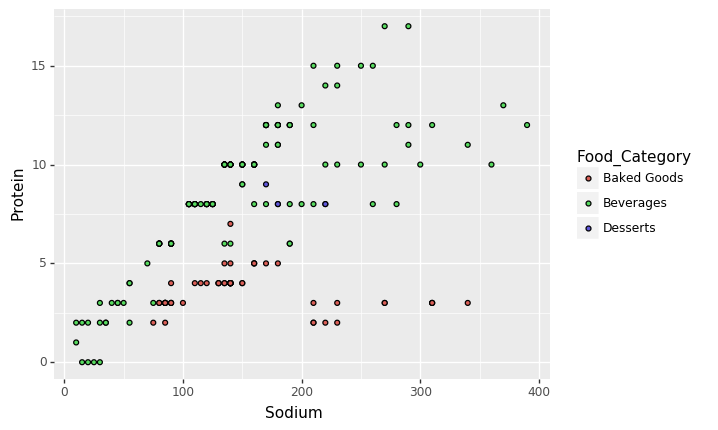

<ggplot: (302429301)>

In [55]:
ggplot(kk, aes("Sodium", "Protein", fill = "Food_Category")) + geom_point()

In [56]:
features = ["Sugar", "Carbohydrates","Sodium", "Protein"]

X = kk[features]
z = StandardScaler()
X[features] = z.fit_transform(X)
Xdf = X


n_components = [2,3,4,5,6]

sils = []
for n in n_components:
    gmm = GaussianMixture(n_components = n)
    gmm.fit(X)
    colName = str(n) + "assign"
    clusters = gmm.predict(X)
    
    Xdf[colName] = clusters
    
    sils.append(silhouette_score(X, clusters))
    
print(sils)

[0.2707908552735736, 0.3468966626050098, 0.4549296028017138, 0.5587478131489594, 0.644772839490956]


6 clusters was the best fit for the Caussian Model

# 4. Describe the clusters 

These clusters both seem to not be as random and spread out. 

# Compare the clusters obtained by the two models.

 I think the clusters for each model are very similar and contain alot of the same members